#Human Activity Recognition Time Series Classification 
      **( Model 1:  LSTM Network )**

a. Import required libraries (keras library).

In [1]:
from numpy import array
from numpy import vstack
from pandas import read_csv
from pandas import DataFrame
from numpy import unique
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import to_categorical
from matplotlib import pyplot
import tensorflow as tf 
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import os

GPU availability (GPU provided by Google Colab)

In [2]:
#Let's check for GPU. However, I've already set GPU as runtime type as GPU
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
#Download Human Activity Recognition data
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
#unzip the data
#!unzip HARDataset.zip

In [5]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
os.chdir("/content/drive/MyDrive")

**Data Pre-processing**

**Load file**

The signals are stored in the Inertial Signals directory under the train and test subdirectories. The
input data is in CSV format where columns are separated by whitespace. Write a function to load
the file as a NumPy array.

In [7]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values 

#Let's check for single file total_acc_y_train
data = load_file('HARDataset/train/Inertial Signals/total_acc_y_train.txt')

#the shape of file
print(data.shape)

(7352, 128)


In [8]:
# load a list of files into a 3D array of [samples, timesteps, features]
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
        
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

# load the total acc data
filenames = ['total_acc_x_train.txt', 'total_acc_y_train.txt', 'total_acc_z_train.txt']
total_acc = load_group(filenames, prefix='HARDataset/train/Inertial Signals/')
print(total_acc.shape)

(7352, 128, 3)


**Load dataset group**

In [9]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


**Load dataset**

In [11]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'HARDataset/')
    print("train dataset shape: ", trainX.shape, trainy.shape)
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'HARDataset/')
    print("Test dataset shape: ", testX.shape, testy.shape)
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("the shapes of trainX, trainy, testX and testy are respectively: \n ")
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy

In [12]:
#the shape of train and test dataset after loading is:
load_dataset()

train dataset shape:  (7352, 128, 9) (7352, 1)
Test dataset shape:  (2947, 128, 9) (2947, 1)
the shapes of trainX, trainy, testX and testy are respectively: 
 
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)


(array([[[ 1.012817e+00, -1.232167e-01,  1.029341e-01, ...,
           3.019122e-02,  6.601362e-02,  2.285864e-02],
         [ 1.022833e+00, -1.268756e-01,  1.056872e-01, ...,
           4.371071e-02,  4.269897e-02,  1.031572e-02],
         [ 1.022028e+00, -1.240037e-01,  1.021025e-01, ...,
           3.568780e-02,  7.485018e-02,  1.324969e-02],
         ...,
         [ 1.018445e+00, -1.240696e-01,  1.003852e-01, ...,
           3.985177e-02,  1.909445e-03, -2.170124e-03],
         [ 1.019372e+00, -1.227451e-01,  9.987355e-02, ...,
           3.744932e-02, -7.982483e-05, -5.642633e-03],
         [ 1.021171e+00, -1.213260e-01,  9.498741e-02, ...,
           2.881781e-02, -3.771800e-05, -1.446006e-03]],
 
        [[ 1.018851e+00, -1.239760e-01,  9.792958e-02, ...,
           1.711106e-02,  6.122797e-03,  1.226815e-02],
         [ 1.022380e+00, -1.268078e-01,  9.935086e-02, ...,
           2.417851e-02,  9.710357e-03,  1.614958e-02],
         [ 1.020781e+00, -1.277862e-01,  9.811381e-02, 

In [13]:
trainX, trainy, testX, testy = load_dataset()

train dataset shape:  (7352, 128, 9) (7352, 1)
Test dataset shape:  (2947, 128, 9) (2947, 1)
the shapes of trainX, trainy, testX and testy are respectively: 
 
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)


** Data Visualization**


In [14]:
def class_breakdown (data):
    #wrapping the provided numpy array in Dataframe
    df= DataFrame(data)
    #grouping the rows by the class values and calculating the size of each group
    counts= df.groupby(0).size()
    counts= counts.values
    #results are then summarized, including count and percentage
    for  i in range(len(counts)):
        percent = counts[i] / len(df) * 100
        print('Class=%d, total=%d, percentage=%.3f' % (i+1, counts[i], percent))

In [15]:
# load train file
trainy = load_file('HARDataset/train/y_train.txt')
# summarize class breakdown
print('Train Dataset')
class_breakdown(trainy)

# load test file
testy = load_file('HARDataset/test/y_test.txt')
# summarize class breakdown
print('Test Dataset')
class_breakdown(testy)

# summarize combined class breakdown
print('Both')
combined = vstack((trainy, testy))
class_breakdown(combined)

Train Dataset
Class=1, total=1226, percentage=16.676
Class=2, total=1073, percentage=14.595
Class=3, total=986, percentage=13.411
Class=4, total=1286, percentage=17.492
Class=5, total=1374, percentage=18.689
Class=6, total=1407, percentage=19.138
Test Dataset
Class=1, total=496, percentage=16.831
Class=2, total=471, percentage=15.982
Class=3, total=420, percentage=14.252
Class=4, total=491, percentage=16.661
Class=5, total=532, percentage=18.052
Class=6, total=537, percentage=18.222
Both
Class=1, total=1722, percentage=16.720
Class=2, total=1544, percentage=14.992
Class=3, total=1406, percentage=13.652
Class=4, total=1777, percentage=17.254
Class=5, total=1906, percentage=18.507
Class=6, total=1944, percentage=18.876


###### **Plot Time Series Data**
- As we are working on time series data, therefore , an important check is to create a line plot of raw data
- The raw data is comprised of windows of time series data per variable and windows do have 50% overlap

In [16]:
# load data
trainX, trainy = load_dataset_group('train', 'HARDataset/')

#Next, we can load the ‘subject_train.txt‘ in the ‘train‘ directory that provides a mapping of rows to 
#the subject to which it belongs.
sub_map = load_file('HARDataset/train/subject_train.txt')

#Once loaded, we can also use the unique() NumPy function to retrieve a list of the unique subjects 
#in the training dataset.
train_subjects = unique(sub_map)
print(train_subjects)

[ 1  3  5  6  7  8 11 14 15 16 17 19 21 22 23 25 26 27 28 29 30]


- Now, we need a way to retrieve all of the rows for a single subject, e.g. subject number 1.
- we can do this by finding all of the row numbers that belong to a given subject and use those row numbers to select the samples from the loaded X and y data from the training dataset.
- To implement this, we will define a function called data_for_subject(). It'll take the loaded training data, the loaded mapping of row number to subjects, and the subject identification number for the subject that we are interested in, and will return the X and y data for only that subject.

In [17]:
# get all data for one subject
def data_for_subject(X, y, sub_map, sub_id):
    # get row indexes for the subject id
    ix = [i for i in range(len(sub_map)) if sub_map[i]==sub_id]
    # return the selected samples
    return X[ix, :, :], y[ix]

- Here, the data is comprised of windows with overlap so we need to write a function to remove this overlap and squash the windows down for a given variable into one long sequence and it can be achieved directly as a line plot.
- We're going to write to_series() function below to achieve our goal. 

In [18]:
# convert a series of windows to a 1D list
def to_series(windows):
    series = list()
    for window in windows:
        # remove the overlap from the window
        half = int(len(window) / 2) - 1
        for value in window[-half:]:
            series.append(value)
            
        
    return series

- We can plot each of the nine variables for the subject in turn and a final plot for the activity level.
- There will be the same number of timesteps (length of x-axis) for each series, therefore, we should create a subplot for each variable and align them vertically in order to compare the movement on each variable.
- we will implement this for X and y data for a single subject using the plot_subject() function. We've made an assumption that the function will have same order of the variables (3rd axis) as was loaded in the load_dataset() function.

In [19]:
def plot_subject(X, y):
    pyplot.figure()
    # determine the total number of plots
    n, off = X.shape[2] + 1, 0
    # plot total acc
    for i in range(3):
        pyplot.subplot(n, 1, off+1)
        pyplot.plot(to_series(X[:, :, off]))
        pyplot.title('total acc '+str(i), y=0, loc='left')
        off += 1
        
    # plot body acc
    for i in range(3):
        pyplot.subplot(n, 1, off+1)
        pyplot.plot(to_series(X[:, :, off]))
        pyplot.title('body acc '+str(i), y=0, loc='left')
        off += 1
        
    # plot body gyro
    for i in range(3):
        pyplot.subplot(n, 1, off+1)
        pyplot.plot(to_series(X[:, :, off]))
        pyplot.title('body gyro '+str(i), y=0, loc='left')
        off += 1
        
    # plot activities
    pyplot.subplot(n, 1, n)
    pyplot.plot(y)
    pyplot.title('activity', y=0, loc='left')
    pyplot.show()

##### **Now, check for the output**

(347, 128, 9) (347, 1)


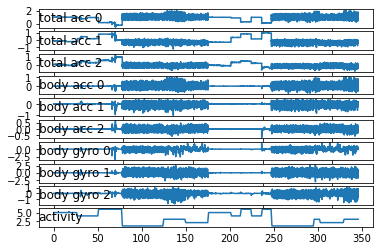

Figure 1: Line plot for all variables for a single subject


In [20]:
# get the data for one subject
sub_id = train_subjects[0]
subX, suby = data_for_subject(trainX, trainy, sub_map, sub_id)
print(subX.shape, suby.shape)
# plot data for subject
plot_subject(subX, suby)

print("Figure 1: Line plot for all variables for a single subject")

keras version  2.4.3


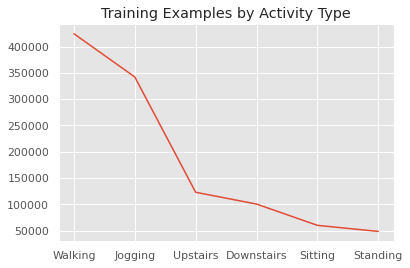

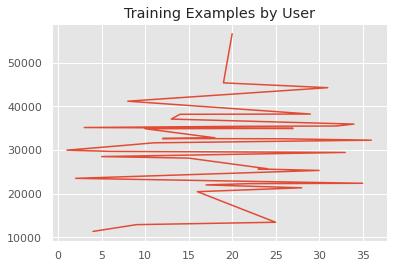

In [21]:
print('keras version ', keras.__version__)
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Walking_upstairs',
          'Walking']

# Show how many training examples exist for each of the six activities
df['activity'].value_counts().plot(kind='line',
                                   title='Training Examples by Activity Type')
plt.show()
# Better understand how the recordings are spread across the different
# users who participated in the study
df['user-id'].value_counts().plot(kind='line',
                                  title='Training Examples by User')
plt.show()

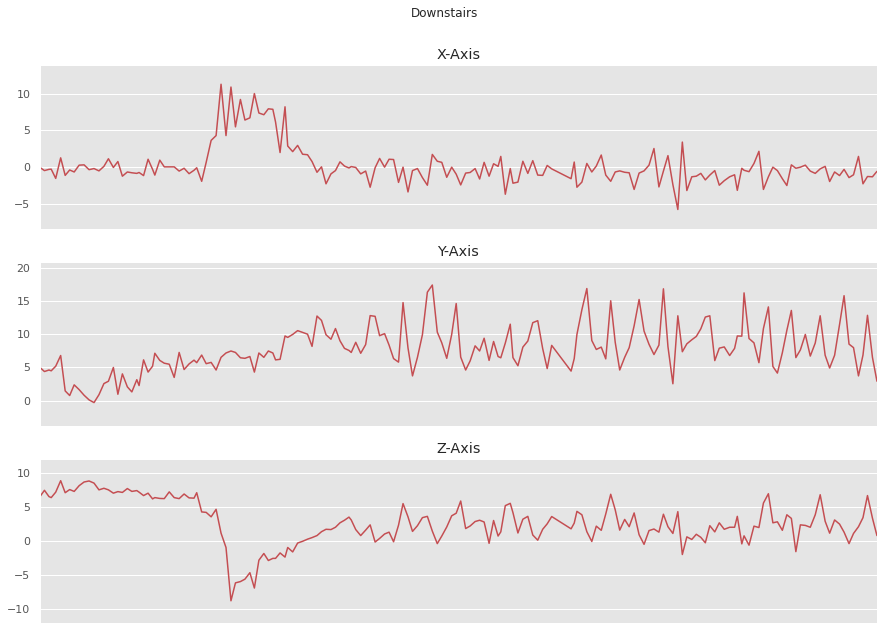

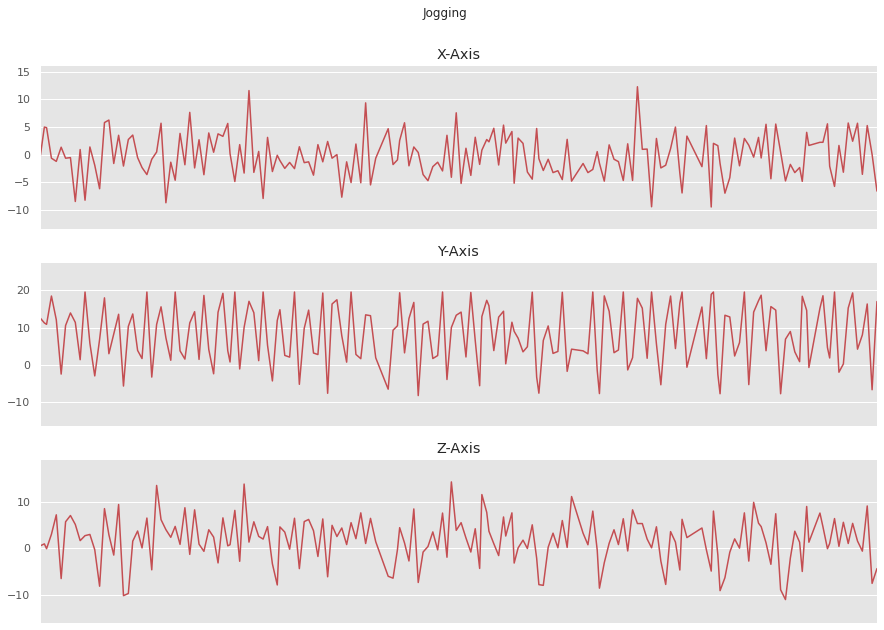

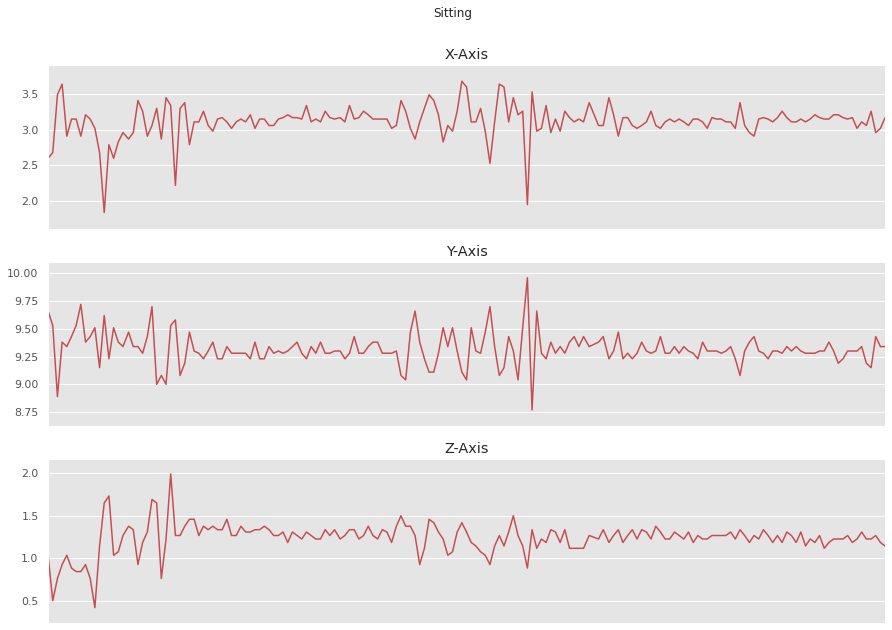

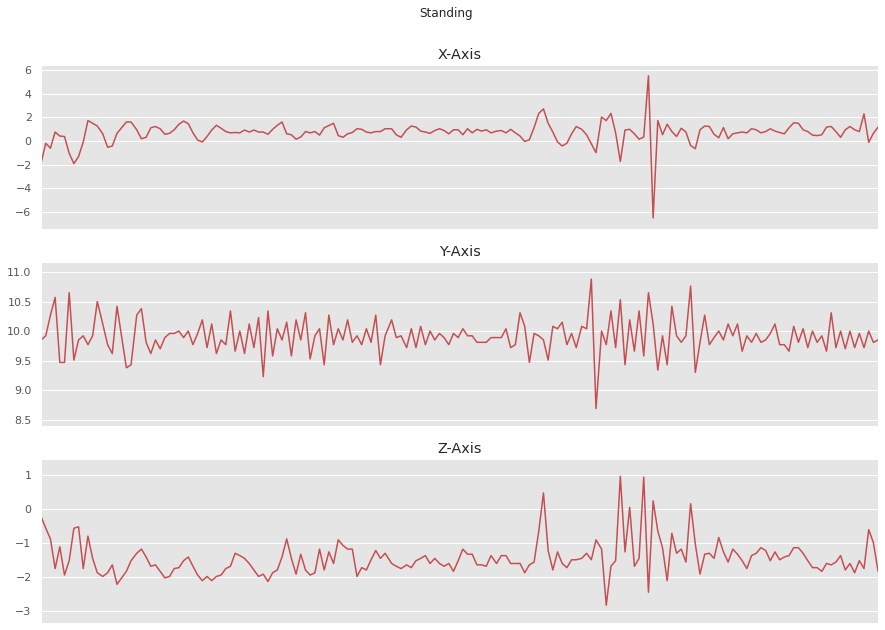

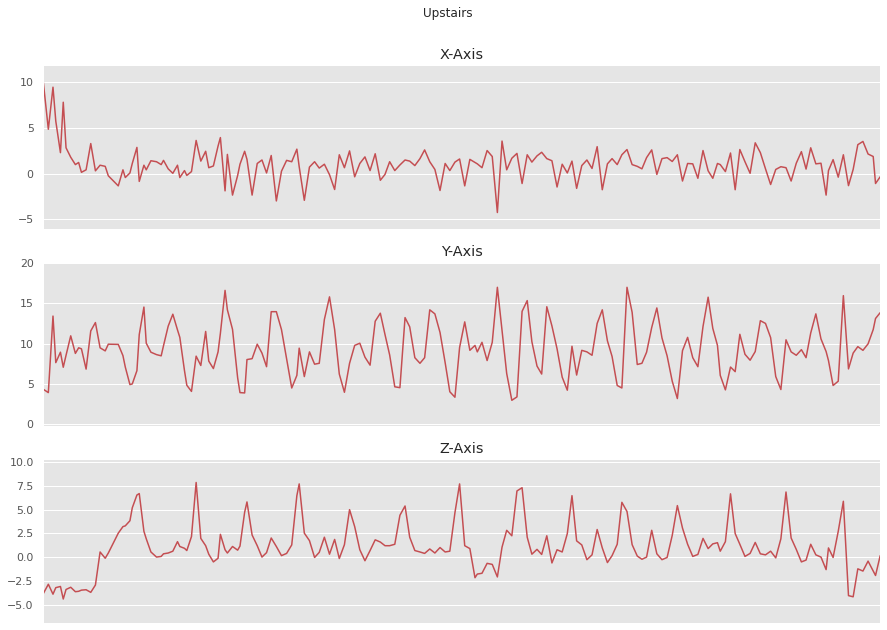

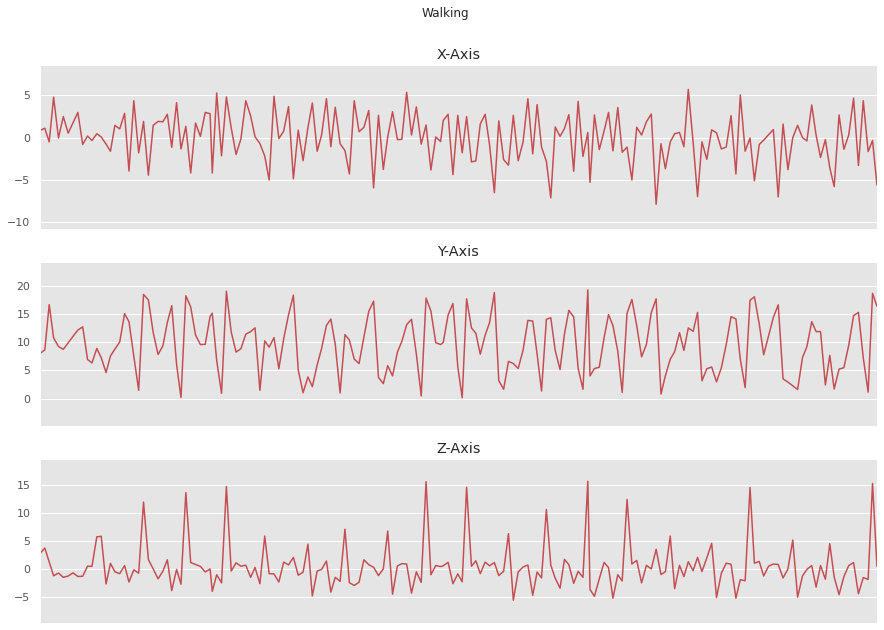

In [22]:
def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:180]
    plot_activity(activity, subset)

#### **Let's do some additional visualizations before modeling for better understanding of the data**

###### **Plotting Histogram per subject**
- We are interested to know the movement data from some subjects to predict activities from the movement of other sujects
- the data has been scaled up between -1  and 1. 
- we would definitely expect that the distribution of movement of data would be similar across the subjects
- For this, we have an approach to create one plot per subject and plot all three axis of a given data (for example total_acceleration), then we repeat this for multiple steps 

In [23]:
# plot histograms for multiple subjects
def plot_subject_histograms(X, y, sub_map, n=10):
    pyplot.figure()
    # get unique subjects
    subject_ids = unique(sub_map[:,0])
    # enumerate subjects
    xaxis = None
    for k in range(n):
        sub_id = subject_ids[k]
        # get data for one subject
        subX, _ = data_for_subject(X, y, sub_map, sub_id)
        # total acc
        for i in range(3):
            ax = pyplot.subplot(n, 1, k+1, sharex=xaxis)
            ax.set_xlim(-1,1)
            if k == 0:
                xaxis = ax
            pyplot.hist(to_series(subX[:,:,i]), bins=100)
    pyplot.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


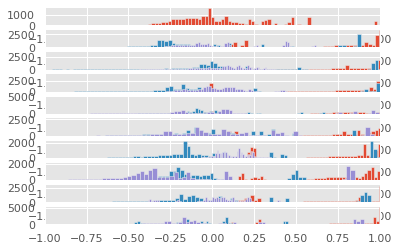

Figure 2: Histograms of the total acceleration data for 10 subjects


In [24]:
# load training dataset
X, y = load_dataset_group('train', 'HARDataset/')
# plot histograms for subjects
plot_subject_histograms(X, y, sub_map)
print("Figure 2: Histograms of the total acceleration data for 10 subjects")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


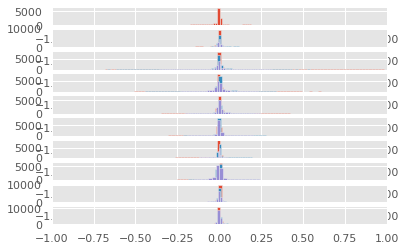

Figure 3: Histograms of the body acceleration data for 10 subjects


In [25]:
# plot histograms for multiple subjects
def plot_subject_histograms(X, y, sub_map, n=10):
    pyplot.figure()
    # get unique subjects
    subject_ids = unique(sub_map[:,0])
    # enumerate subjects
    xaxis = None
    for k in range(n):
        sub_id = subject_ids[k]
        # get data for one subject
        subX, _ = data_for_subject(X, y, sub_map, sub_id)
        # body acc
        for i in range(3):
            ax = pyplot.subplot(n, 1, k+1, sharex=xaxis)
            ax.set_xlim(-1,1)
            if k == 0:
                xaxis = ax
                
            pyplot.hist(to_series(subX[:,:,3+i]), bins=100)
    pyplot.show()

  # plot histograms for subjects
plot_subject_histograms(X, y, sub_map)
print("Figure 3: Histograms of the body acceleration data for 10 subjects")

In [26]:
# plot histograms for multiple subjects
def plot_subject_histograms(X, y, sub_map, n=10):
    pyplot.figure()
    # get unique subjects
    subject_ids = unique(sub_map[:,0])
    # enumerate subjects
    xaxis = None
    for k in range(n):
        sub_id = subject_ids[k]
        # get data for one subject
        subX, _ = data_for_subject(X, y, sub_map, sub_id)
        # body acc
        for i in range(3):
            ax = pyplot.subplot(n, 1, k+1, sharex=xaxis)
            ax.set_xlim(-1,1)
            if k == 0:
                xaxis = ax
            pyplot.hist(to_series(subX[:,:,6+i]), bins=100)
    pyplot.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


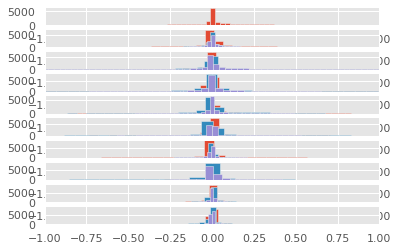

Figure 4: Histograms of the  body gyroscope data for 10 subjects


In [27]:
# plot histograms for subjects
plot_subject_histograms(X, y, sub_map)
print("Figure 4: Histograms of the  body gyroscope data for 10 subjects")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


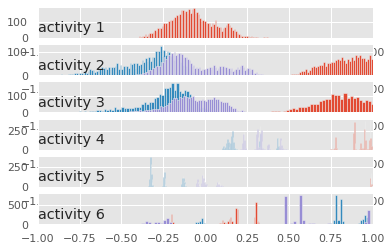

          Activity 1: Walking, Activity 2: Walking_upstairs

Figure 5: Histograms of the total acceleration data by activity


In [28]:
# group data by activity
def data_by_activity(X, y, activities):
    # group windows by activity
    return {a:X[y[:,0]==a, :, :] for a in activities}

# plot histograms for each activity for a subject
def plot_activity_histograms(X, y):
    # get a list of unique activities for the subject
    activity_ids = unique(y[:,0])
    # group windows by activity
    grouped = data_by_activity(X, y, activity_ids)
    # plot per activity, histograms for each axis
    pyplot.figure()
    xaxis = None
    for k in range(len(activity_ids)):
        act_id = activity_ids[k]
        # total acceleration
        for i in range(3):
            ax = pyplot.subplot(len(activity_ids), 1, k+1, sharex=xaxis)
            ax.set_xlim(-1,1)
            if k == 0:
                xaxis = ax
                
            pyplot.hist(to_series(grouped[act_id][:,:,i]), bins=100)
            pyplot.title('activity '+str(act_id), y=0, loc='left')
            
    pyplot.show()
 
# load data
trainX, trainy = load_dataset_group('train', 'HARDataset/')
# load mapping of rows to subjects
sub_map = load_file('HARDataset/train/subject_train.txt')
train_subjects = unique(sub_map)
# get the data for one subject
sub_id = train_subjects[0]
subX, suby = data_for_subject(trainX, trainy, sub_map, sub_id)
# plot data for subject
plot_activity_histograms(subX, suby)
print("          Activity 1: Walking, Activity 2: Walking_upstairs\n")
print("Figure 5: Histograms of the total acceleration data by activity")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


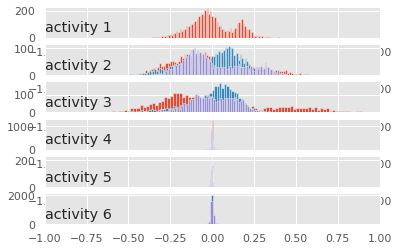

                Activity 1: Walking, Activity 2: Walking_upstairs

Figure 6: Histograms of the body acceleration data by activity


In [29]:
# plot histograms for each activity for a subject
def plot_activity_histograms(X, y):
    # get a list of unique activities for the subject
    activity_ids = unique(y[:,0])
    # group windows by activity
    grouped = data_by_activity(X, y, activity_ids)
    # plot per activity, histograms for each axis
    pyplot.figure()
    xaxis = None
    for k in range(len(activity_ids)):
        act_id = activity_ids[k]
        # total acceleration
        for i in range(3):
            ax = pyplot.subplot(len(activity_ids), 1, k+1, sharex=xaxis)
            ax.set_xlim(-1,1)
            if k == 0:
                xaxis = ax
            pyplot.hist(to_series(grouped[act_id][:,:,3+i]), bins=100)
            pyplot.title('activity '+str(act_id), y=0, loc='left')
    pyplot.show()

plot_activity_histograms(subX, suby)
print("                Activity 1: Walking, Activity 2: Walking_upstairs\n")
print("Figure 6: Histograms of the body acceleration data by activity")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


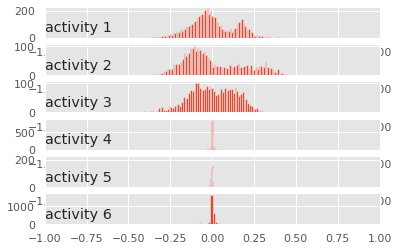

                Activity 1: Walking, Activity 2: Walking_upstairs

Figure 7 : Histograms of the  body gyroscope  data by activity


In [30]:
# plot histograms for each activity for a subject
def plot_activity_histograms(X, y):
    # get a list of unique activities for the subject
    activity_ids = unique(y[:,0])
    # group windows by activity
    grouped = data_by_activity(X, y, activity_ids)
    # plot per activity, histograms for each axis
    pyplot.figure()
    xaxis = None
    for k in range(len(activity_ids)):
        act_id = activity_ids[k]
        # total acceleration
        for i in range(3):
            ax = pyplot.subplot(len(activity_ids), 1, k+1, sharex=xaxis)
            ax.set_xlim(-1,1)
            if k == 0:
                xaxis = ax
        pyplot.hist(to_series(grouped[act_id][:,:,3+i]), bins=100)
        pyplot.title('activity '+str(act_id), y=0, loc='left')
    pyplot.show()

plot_activity_histograms(subX, suby)
print("                Activity 1: Walking, Activity 2: Walking_upstairs\n")
print("Figure 7 : Histograms of the  body gyroscope  data by activity")

## Model 1:LSTM Network Model**

**Model Building**

In [31]:
verbose, epochs, batch_size = 0, 15, 64
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               44000     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 54,201
Trainable params: 54,201
Non-trainable params: 0
_________________________________________________________________


**Model Compilation**

In [32]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

**Model Training**

In [33]:
# fit network
model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)

**loss and accuracy history graphs**

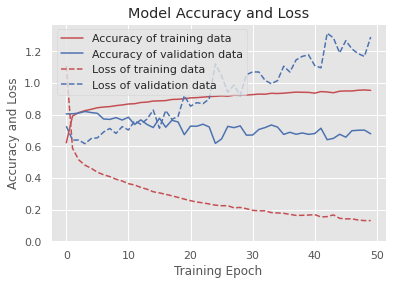

              precision    recall  f1-score   support

         0.0       0.73      0.72      0.72      1864
         1.0       0.99      0.96      0.97      6567
         2.0       1.00      1.00      1.00      1050
         3.0       0.99      1.00      1.00       833
         4.0       0.69      0.84      0.75      2342
         5.0       0.94      0.90      0.92      8212

    accuracy                           0.90     20868
   macro avg       0.89      0.90      0.89     20868
weighted avg       0.91      0.90      0.91     20868



In [35]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

# Print confusion matrix for training data
y_pred_train = model_m.predict(x_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(y_train, max_y_pred_train))

**Model Evaluation**

In [36]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy
 
# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))
 
# run an experiment
def run_experiment(repeats=10):
    # load data
    trainX, trainy, testX, testy = load_dataset()
    # repeat experiment
    scores = list()
    for r in range(repeats):
        score = evaluate_model(trainX, trainy, testX, testy)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
    scores.append(score)
    # summarize results
    summarize_results(scores)
 
# run the experiment
run_experiment()

train dataset shape:  (7352, 128, 9) (7352, 1)
Test dataset shape:  (2947, 128, 9) (2947, 1)
the shapes of trainX, trainy, testX and testy are respectively: 
 
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
>#1: 91.449
>#2: 84.696
>#3: 91.517
>#4: 91.449
>#5: 89.786
>#6: 90.770
>#7: 90.261
>#8: 90.872
>#9: 89.345
>#10: 91.856
[91.44893288612366, 84.69629883766174, 91.51679873466492, 91.44893288612366, 89.78622555732727, 90.77027440071106, 90.26128053665161, 90.87207317352295, 89.34509754180908, 91.85612201690674]
Accuracy: 90.200% (+/-1.989)


**confusion matrix**

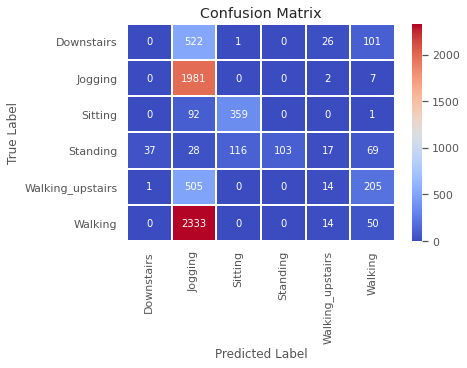

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       650
           1       0.36      1.00      0.53      1990
           2       0.75      0.79      0.77       452
           3       1.00      0.28      0.44       370
           4       0.19      0.02      0.04       725
           5       0.12      0.02      0.04      2397

    accuracy                           0.38      6584
   macro avg       0.40      0.35      0.30      6584
weighted avg       0.28      0.38      0.26      6584



In [37]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_test = model_m.predict(testX)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(testy, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print(classification_report(max_y_test, max_y_pred_test))